In [91]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim


from models.learned_qp_solver_bi_cycle_steer_part import MLP_Init, learned_qp_solver
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
# torch.set_default_dtype(torch.float64)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [93]:


num = 50
t = 0.1


steer_min = -0.8
steer_max = 0.8

steerdot_min = -1.0
steerdot_max = 1.0

steerddot_min = -1.0
steerddot_max = 1.0



In [94]:
#### creating dataset 

steer_des =  np.random.uniform(steer_min, steer_max)

num_batch = 500

# vel_samples = np.random.uniform(vel_min, vel_max,  (num_batch, num)    )
steer_samples = np.random.multivariate_normal(steer_des*np.ones(num), 1*np.identity(num), (num_batch, ) )


steer_samples = np.clip( steer_samples, steer_min, steer_max  )


# vel_init = np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
steer_init = steer_des*np.ones((num_batch , 1)) 


inp = np.hstack(( steer_samples, steer_init))


median_ = np.array([-4.30842576e-04,  5.91636819e-05, -1.98533905e-03,  1.95326047e-03,
       -1.39358004e-03, -5.68464714e-05,  2.65373538e-04, -2.05526464e-03,
       -7.79943244e-04, -2.89536127e-04, -1.67782600e-03, -1.30369985e-03,
        1.54351594e-03, -2.10914668e-03, -8.94449061e-04, -1.12731106e-04,
        1.39067091e-03,  2.35456389e-03,  1.13105755e-03, -1.60172509e-03,
        5.96616154e-04,  4.50916455e-04,  1.03440312e-03,  2.20521562e-03,
        1.91066337e-03, -2.36909941e-03,  5.23557830e-04,  3.22519684e-03,
       -6.10364108e-04, -1.55881571e-03, -2.54650519e-04,  5.49939732e-04,
       -2.54372567e-03,  1.15624681e-03,  3.09751082e-03, -1.01707749e-03,
       -1.16847934e-03, -9.60229520e-04,  3.19715942e-04, -7.80995571e-04,
        3.91363172e-04,  1.96635947e-05, -2.01634184e-04, -1.34935042e-03,
       -1.25220145e-03,  1.28156314e-04,  1.63297072e-03, -2.31602556e-03,
        8.75998110e-04, -2.06147938e-04,  1.15305881e-03])
iqr_ = np.array([0.80001846, 0.79929592, 0.79676276, 0.79730429, 0.79646984,
       0.79966968, 0.80083456, 0.80339261, 0.79957275, 0.80271643,
       0.79956587, 0.7986954 , 0.80184285, 0.79680465, 0.79700468,
       0.80111911, 0.80292797, 0.79760931, 0.8001852 , 0.79991013,
       0.80251082, 0.80016607, 0.80274812, 0.7996054 , 0.79708629,
       0.79890295, 0.8011802 , 0.79833857, 0.80142342, 0.80023931,
       0.80009408, 0.79791844, 0.79955642, 0.79824443, 0.79912222,
       0.79983322, 0.80107271, 0.79787763, 0.80142027, 0.79819341,
       0.79860864, 0.79933899, 0.7980339 , 0.79911936, 0.79988434,
       0.79932644, 0.79560559, 0.79765311, 0.79994117, 0.80107361,
       0.79731313])


median_ = torch.tensor(median_).float().to(device)
iqr_ = torch.tensor(iqr_).float().to(device)



In [95]:
# Differentiable Layer

mlp_init_inp_dim = np.shape(inp)[1]
mlp_init_hidden_dim = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim = num+(2*num+2*(num-1)+2*(num-2))
# print((2*num+2*(num-1)+2*(num-2)))

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init = MLP_Init(mlp_init_inp_dim, mlp_init_hidden_dim, mlp_init_out_dim  )


model = learned_qp_solver(num_batch, num, t, mlp_init).to(device)
model.load_state_dict(torch.load('./weights/learned_qp_bi_cycle_steer_part.pth'))
# model.load_state_dict(torch.load('./weights/learned_qp_bi_cycle_vel_part.pth'))



<All keys matched successfully>

[0.24519011 0.05970374 0.05035179 0.04393005 0.03929198]
[0. 0. 0. 0. 0.]


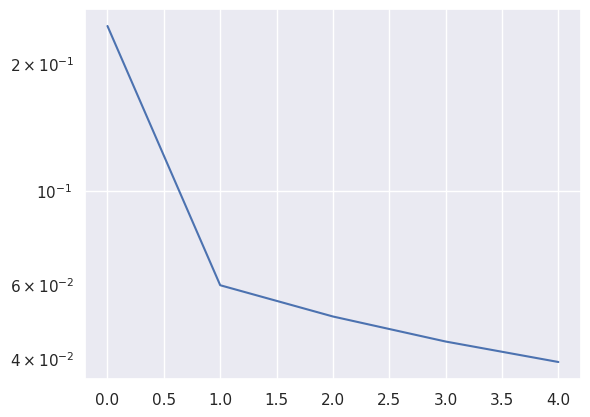

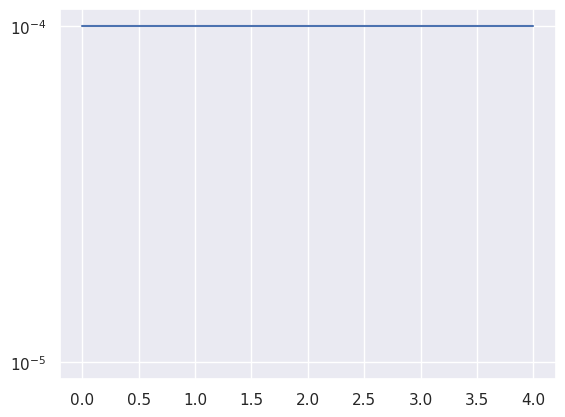

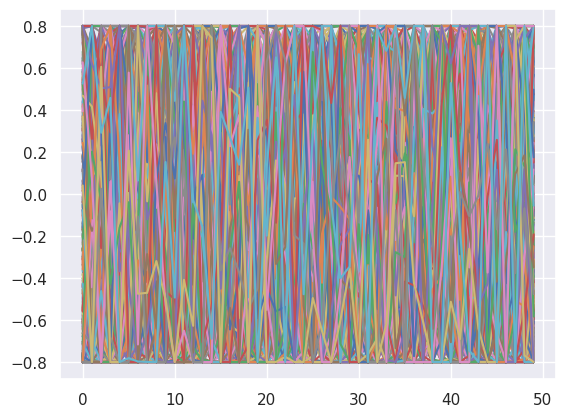

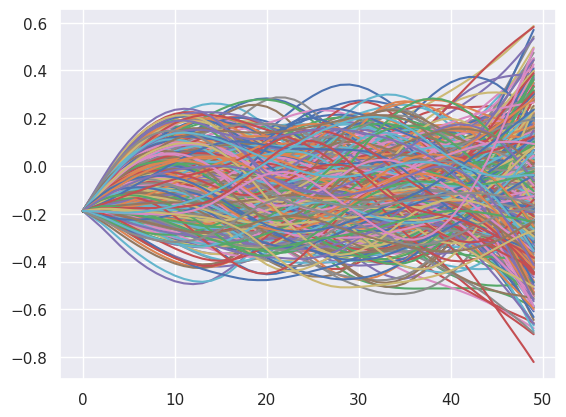

In [96]:
#################3


inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
# inp_norm_test = (inp_test - inp_mean) / inp_std
inp_norm_test = (inp_test-median_)/iqr_
# inp_norm_test = (inp_test - inp_min) / (inp_max-inp_min)

# inp_norm_test = inp_test 



steer_init_test = steer_init[0]
steer_init_test = torch.tensor(steer_init_test).float()
steer_init_test = steer_init_test.to(device)



# vel_init_test = torch.vstack([vel_init_test] * num_batch)


steer_samples_test = steer_samples
steer_samples_test = torch.tensor(steer_samples_test).float()
steer_samples_test = steer_samples_test.to(device)
# vel_samples_test = torch.vstack([vel_samples_test] * num_batch)

with torch.no_grad():
    steer_projected, res_primal_stack, res_fixed_point_stack, accumulated_res_primal, accumulated_res_fixed_point = model.decoder_function( inp_norm_test, steer_init_test, steer_samples_test, steer_max, steer_min, steerdot_max, steerdot_min, steerddot_max, steerddot_min)



print(res_fixed_point_stack[:, 0].cpu().detach().numpy())
print(res_primal_stack[:, 0].cpu().detach().numpy())

plt.figure(1)
plt.plot(res_fixed_point_stack[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(3)

plt.plot(steer_samples_test.T.cpu().detach().numpy())

plt.figure(4)
plt.plot(steer_projected.T.cpu().detach().numpy())

plt.show()


